In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from io import StringIO
import requests

# Konfigurasi Tampilan Pandas agar angka tidak disingkat
pd.set_option('display.float_format', lambda x: '%.2f' % x)

sheet_id = "12I58v86gJ1-69_mlLAfb5esZzOoc1pls5vQY3MM4UPw"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv"

try:
    response = requests.get(url)
    response.raise_for_status()
    df = pd.read_csv(StringIO(response.text), on_bad_lines='skip')
    # Standarisasi nama kolom (Huruf kecil semua biar mudah dipanggil)
    df.columns = df.columns.str.strip().str.lower()
    print("✅ Data Berhasil Dimuat dari Google Sheets!")
except Exception as e:
    print(f"❌ Gagal Load Otomatis: {e}")
    # df = pd.read_csv

print("\n--- MENAMPILKAN 5 DATA TERATAS (HEAD) ---")
display(df.head())

--- 1. DATA LOADING ---
✅ Data Berhasil Dimuat dari Google Sheets!

--- MENAMPILKAN 5 DATA TERATAS (HEAD) ---


,kode,nama perusahaan,price,price open,volume perdagangan,marketcap,eps,pe,harga terendah dlm 52,harga tertinggi dlm 52,unnamed: 10
0,AADI,PT Adaro Andalan Indonesia Tbk,7450.00,7575.00,5.637.100,Rp58.012.337.950.000,"916,03","8,13","5.575,00","11.375,00",7450
1,ACES,PT Ace Hardware Indonesia Tbk,420.00,422.00,12.596.500,Rp7.156.323.020.000,"47,58","8,83","412,00","830,00",NaN
2,ADMR,PT Adaro Minerals Indonesia Tbk,1450.00,1450.00,126.929.400,Rp59.074.966.850.000,"125,47","11,52","700,00","1.540,00",#ERROR!
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AKRA,PT AKR Corporindo Tbk,1250.00,1285.00,5.150.400,Rp25.192.204.850.000,"121,88","10,21","890,00","1.430,00",NaN


In [ ]:
# CELL 2: DATA UNDERSTANDING
print("\n--- 2. DATA INFO (TIPE DATA) ---")
# Kita cek apakah kolom Price/EPS terbaca sebagai Angka (Float) atau Teks (Object)
print(df.info())

print("\n--- PENGECEKAN NILAI KOSONG (MISSING VALUES) ---")
print(df.isnull().sum())

print("\n--- ANALISIS BISNIS SEDERHANA ---")
# Cek kolom yang tersedia
cols = list(df.columns)
print(f"Kolom yang tersedia: {cols}")
print("Catatan: Data keuangan Google Finance biasanya bertipe 'Object' (Teks) karena mengandung simbol mata uang.")


--- 2. DATA INFO (TIPE DATA) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   kode                    46 non-null     object 
 1   nama perusahaan         44 non-null     object 
 2   price                   44 non-null     float64
 3   price open              44 non-null     float64
 4   volume perdagangan      36 non-null     object 
 5   marketcap               44 non-null     object 
 6   eps                     44 non-null     object 
 7   pe                      40 non-null     object 
 8   harga terendah dlm 52   44 non-null     object 
 9   harga tertinggi dlm 52  44 non-null     object 
 10  unnamed: 10             2 non-null      object 
dtypes: float64(2), object(9)
memory usage: 4.7+ KB
None

--- PENGECEKAN NILAI KOSONG (MISSING VALUES) ---
kode                       7
nama perusahaan            9
price    

In [ ]:
# CELL 3: DATA CLEANING
print("\n--- 3. DATA CLEANING ---")

# Fungsi Pembersih (Handle T, B, M, Rp)
def clean_money_format(x):
    s = str(x).upper().replace('RP', '').strip()
    if s in ['-', '', 'NAN', 'NONE']: return np.nan

    # Handle Suffix
    multiplier = 1
    if 'T' in s: multiplier=1e12; s=s.replace('T', '')
    elif 'B' in s: multiplier=1e9; s=s.replace('B', '')
    elif 'M' in s: multiplier=1e6; s=s.replace('M', '')

    try:
        # Hapus titik ribuan, ganti koma desimal jadi titik
        s = s.replace('.', '').replace(',', '.')
        return float(s) * multiplier
    except: return np.nan

# Identifikasi Kolom secara Otomatis
col_price = [c for c in df.columns if 'price' in c][0]
col_eps = [c for c in df.columns if 'eps' in c][0]
col_name = [c for c in df.columns if 'name' in c][0]

# Terapkan Pembersihan
df_clean = df.copy()
df_clean['Price_Clean'] = df_clean[col_price].apply(clean_money_format)
df_clean['EPS_Clean'] = df_clean[col_eps].apply(clean_money_format)
df_clean['Name_Clean'] = df_clean[col_name]

# Hapus data yang gagal dibersihkan (NaN)
df_clean = df_clean.dropna(subset=['Price_Clean', 'EPS_Clean'])

print("✅ Data telah dibersihkan.")
print("Contoh Data Bersih:")
display(df_clean[['Name_Clean', 'Price_Clean', 'EPS_Clean']].head())

print("\n--- STATISTIK DESKRIPTIF (DESCRIBE) ---")
# Melihat rata-rata, min, max harga saham
display(df_clean[['Price_Clean', 'EPS_Clean']].describe())


--- 3. DATA CLEANING ---
✅ Data telah dibersihkan.
Contoh Data Bersih:


,Name_Clean,Price_Clean,EPS_Clean
0,7450,74500.00,916.03
1,NaN,4200.00,47.58
2,#ERROR!,14500.00,125.47
4,NaN,12500.00,121.88
6,NaN,19200.00,63.41



--- STATISTIK DESKRIPTIF (DESCRIBE) ---


,Price_Clean,EPS_Clean
count,44.00,44.00
mean,39978.64,386.17
std,53519.76,805.84
min,710.00,-110.39
25%,11950.00,51.09
50%,23650.00,129.39
75%,44000.00,373.93
max,292500.00,4244.36



--- 4. VISUALISASI SEBARAN DATA ---


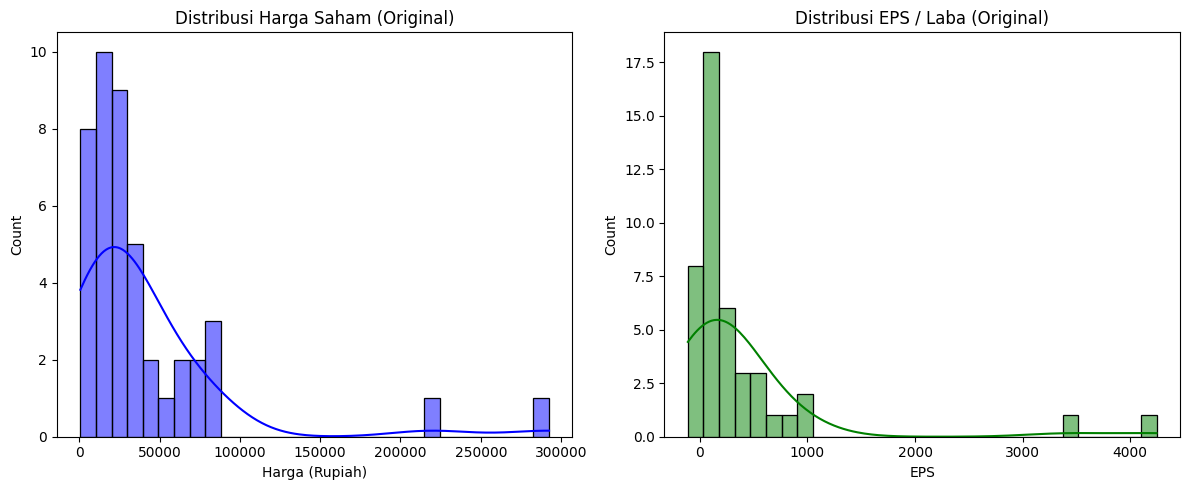

INSIGHT:
Data terlihat sangat 'timpang' (Skewed). Kebanyakan saham harganya kecil, tapi ada sedikit yang harganya raksasa.
Oleh karena itu, kita WAJIB menggunakan Log Transformation sebelum masuk ke Machine Learning.


In [ ]:
# CELL 4: VISUALISASI DISTRIBUSI
print("\n--- 4. VISUALISASI SEBARAN DATA ---")

plt.figure(figsize=(12, 5))

# Plot 1: Histogram Harga
plt.subplot(1, 2, 1)
sns.histplot(df_clean['Price_Clean'], bins=30, kde=True, color='blue')
plt.title('Distribusi Harga Saham (Original)')
plt.xlabel('Harga (Rupiah)')

# Plot 2: Histogram EPS
plt.subplot(1, 2, 2)
sns.histplot(df_clean['EPS_Clean'], bins=30, kde=True, color='green')
plt.title('Distribusi EPS / Laba (Original)')
plt.xlabel('EPS')

plt.tight_layout()
plt.show()

print("INSIGHT:")
print("Data terlihat sangat 'timpang' (Skewed). Kebanyakan saham harganya kecil, tapi ada sedikit yang harganya raksasa.")
print("Oleh karena itu, kita WAJIB menggunakan Log Transformation sebelum masuk ke Machine Learning.")

In [ ]:
# CELL 5: PREPROCESSING
print("\n--- 5. FILTERING & TRANSFORMATION ---")

# Filter Logika Bisnis:
# Kita hanya analisis perusahaan yang UNTUNG (EPS > 0) dan Harga > 50 (Bukan saham tidur mati)
df_model = df_clean[(df_clean['EPS_Clean'] > 0) & (df_clean['Price_Clean'] > 50)].copy()

print(f"Jumlah Data Valid untuk Analisis: {len(df_model)} Saham.")

# Transformasi Logaritma
# X = Fitur (Laba), y = Target (Harga)
X = np.log10(df_model[['EPS_Clean']])
y = np.log10(df_model['Price_Clean'])

print("Data siap untuk Modelling.")


--- 5. FILTERING & TRANSFORMATION ---
Jumlah Data Valid untuk Analisis: 40 Saham.
Data siap untuk Modelling.


In [ ]:
# CELL 6: MODELLING (MODEL COMPARISON)
print("\n--- 6. MODELLING: LINEAR REGRESSION VS RANDOM FOREST ---")

# 1. Linear Regression
model_lr = LinearRegression()
model_lr.fit(X, y)
pred_lr = model_lr.predict(X)

# 2. Random Forest
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X, y.values.ravel())
pred_rf = model_rf.predict(X)

# Evaluasi
r2_lr = r2_score(y, pred_lr)
r2_rf = r2_score(y, pred_rf)

print(f"📊 Akurasi Linear Regression (R2): {r2_lr:.2f}")
print(f"📊 Akurasi Random Forest    (R2): {r2_rf:.2f}")

# Kita pilih Random Forest untuk rekomendasi karena biasanya lebih akurat
df_model['Fair_Value'] = 10 ** pred_rf  # Kembalikan ke Rupiah
df_model['Diskon_%'] = ((df_model['Fair_Value'] - df_model['Price_Clean']) / df_model['Price_Clean']) * 100

def set_status(x):
    if x > 20: return "UNDERVALUED (Murah)"
    elif x < -20: return "OVERVALUED (Mahal)"
    else: return "FAIR PRICE (Wajar)"

df_model['Status'] = df_model['Diskon_%'].apply(set_status)


--- 6. MODELLING: LINEAR REGRESSION VS RANDOM FOREST ---
📊 Akurasi Linear Regression (R2): 0.58
📊 Akurasi Random Forest    (R2): 0.96



--- 7. EVALUASI VISUAL & REKOMENDASI ---


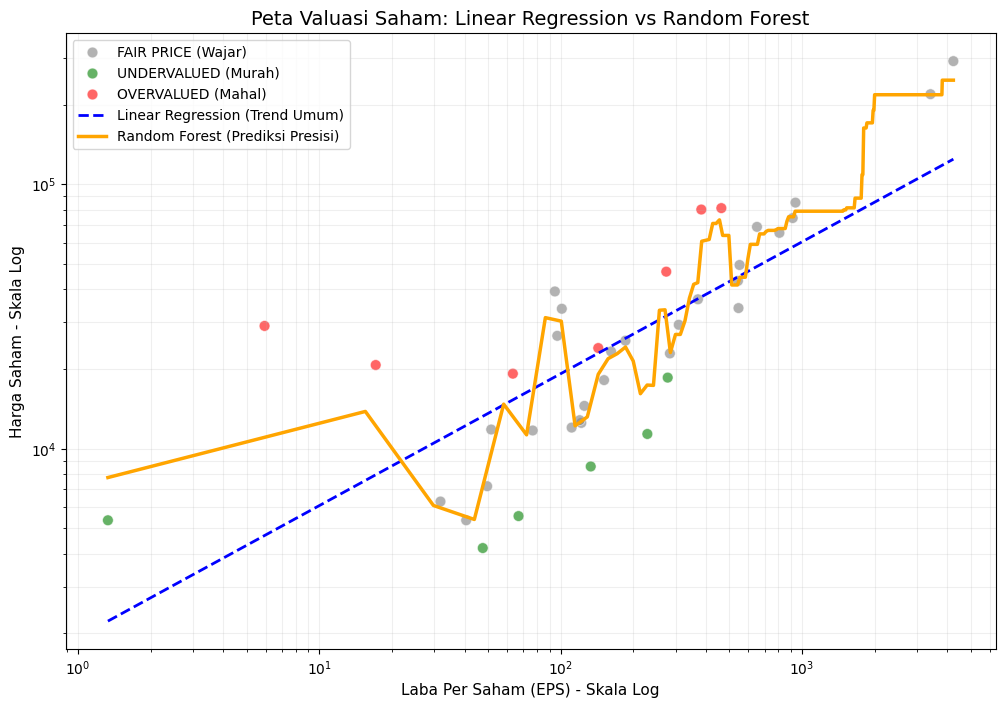


=== TOP 10 SAHAM PALING MURAH (UNDERVALUED) ===
Rekomendasi berdasarkan perhitungan Random Forest (Model Terbaik):


,Name_Clean,Price_Clean,EPS_Clean,Fair_Value,Status,Diskon_%
39,NaN,"5,550",66.94,"8,529",UNDERVALUED (Murah),53.7%
13,NaN,"11,350",228.86,"17,383",UNDERVALUED (Murah),53.2%
31,NaN,"5,350",1.33,"7,764",UNDERVALUED (Murah),45.1%
43,NaN,"18,550",277.89,"24,239",UNDERVALUED (Murah),30.7%
18,NaN,"8,550",133.31,"11,164",UNDERVALUED (Murah),30.6%
1,NaN,"4,200",47.58,"5,426",UNDERVALUED (Murah),29.2%


In [ ]:
# CELL 7: EVALUASI VISUAL (DUA GARIS PREDIKSI) & REKOMENDASI
print("\n--- 7. EVALUASI VISUAL & REKOMENDASI ---")

plt.figure(figsize=(12, 8))

# 1. Scatter Plot Data Asli (Titik-titik Saham)
# Warna titik berdasarkan status (Mahal/Murah) hasil Random Forest
sns.scatterplot(x=df_model['EPS_Clean'], y=df_model['Price_Clean'],
                hue=df_model['Status'],
                palette={'UNDERVALUED (Murah)':'green', 'FAIR PRICE (Wajar)':'grey', 'OVERVALUED (Mahal)':'red'},
                alpha=0.6, s=60)

# Membuat Data Dummy untuk Garis Prediksi (agar garisnya mulus)
x_dummy = np.linspace(df_model['EPS_Clean'].min(), df_model['EPS_Clean'].max(), 300)
x_dummy_log = np.log10(x_dummy.reshape(-1, 1))

# 2. Garis Linear Regression (Garis Lurus Biru)
# Ini menunjukkan "Rata-rata Pasar"
y_pred_lr = 10 ** model_lr.predict(x_dummy_log)
plt.plot(x_dummy, y_pred_lr, color='blue', linestyle='--', linewidth=2, label=f'Linear Regression (Trend Umum)')

# 3. Garis Random Forest (Garis Bergerigi Oranye)
# Ini menunjukkan "Prediksi Detail AI"
y_pred_rf = 10 ** model_rf.predict(x_dummy_log)
plt.plot(x_dummy, y_pred_rf, color='orange', linestyle='-', linewidth=2.5, label=f'Random Forest (Prediksi Presisi)')

# Setting Grafik
plt.xscale('log'); plt.yscale('log')
plt.title('Peta Valuasi Saham: Linear Regression vs Random Forest', fontsize=14)
plt.xlabel('Laba Per Saham (EPS) - Skala Log', fontsize=11)
plt.ylabel('Harga Saham - Skala Log', fontsize=11)
plt.legend(loc='upper left')
plt.grid(True, which="both", alpha=0.2)
plt.show()

# Tampilkan Insight Tabel
print("\n=== TOP 10 SAHAM PALING MURAH (UNDERVALUED) ===")
print("Rekomendasi berdasarkan perhitungan Random Forest (Model Terbaik):")
top_picks = df_model[df_model['Status'] == 'UNDERVALUED (Murah)'].sort_values('Diskon_%', ascending=False).head(10)

# Format tabel output
output = top_picks[['Name_Clean', 'Price_Clean', 'EPS_Clean', 'Fair_Value', 'Status', 'Diskon_%']]
output['Price_Clean'] = output['Price_Clean'].map('{:,.0f}'.format)
output['Fair_Value'] = output['Fair_Value'].map('{:,.0f}'.format)
output['Diskon_%'] = output['Diskon_%'].map('{:.1f}%'.format)

display(output)